**IMPORT LIBRARY**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   

In [32]:
df = pd.read_csv('HR_DATA.csv', sep=';')
df.head()

,RequestID,EmpID,EmpName,Dept,Request_Date,Completion_Date,Request_Detail,PIC
0,REQ0001,103,Charlie Davis,HR,01/01/2024,09/01/2024,Payroll Issue,Sarah Supervisor
1,REQ0002,103,Charlie Davis,HR,01/01/2024,02/01/2024,Access Approval,John Manager
2,REQ0003,105,Eve Wilson,HR,01/01/2024,03/01/2024,Access Approval,John Manager
3,REQ0004,104,David Brown,HR,02/01/2024,10/01/2024,Payroll Issue,Sarah Supervisor
4,REQ0005,102,Bob Smith,HR,02/01/2024,04/01/2024,Benefit Claim,John Manager


In [33]:
df.dtypes

RequestID          object
EmpID               int64
EmpName            object
Dept               object
Request_Date       object
Completion_Date    object
Request_Detail     object
PIC                object
dtype: object

In [34]:
df.isna().sum()

RequestID           0
EmpID               0
EmpName             0
Dept                0
Request_Date        9
Completion_Date    93
Request_Detail      6
PIC                 5
dtype: int64

In [35]:
df['Request_Detail'] = df['Request_Detail'].fillna(df['Request_Detail'].mode()[0])
df['PIC'] = df['PIC'].fillna(df['PIC'].mode()[0])

df.isna().sum()

RequestID           0
EmpID               0
EmpName             0
Dept                0
Request_Date        9
Completion_Date    93
Request_Detail      0
PIC                 0
dtype: int64

In [36]:
df['Completion_Date'] = pd.to_datetime(df['Completion_Date'], format='%d/%m/%Y')
df['Request_Date'] = pd.to_datetime(df['Request_Date'], format='%d/%m/%Y')

df.dtypes

RequestID                  object
EmpID                       int64
EmpName                    object
Dept                       object
Request_Date       datetime64[ns]
Completion_Date    datetime64[ns]
Request_Detail             object
PIC                        object
dtype: object

In [37]:
inflow = df['Request_Date'].notna().sum()
outflow = df['Completion_Date'].notna().sum()
backlog = df[df['Request_Date'].notna() & df['Completion_Date'].isna()].shape[0]
open_req = df[df['Request_Date'].isna()].shape[0]

print(inflow)
print(outflow)
print(backlog)
print(open_req)

991
907
93
9


In [38]:
df['Processing Days'] = df.apply(
    lambda row: np.busday_count(row['Request_Date'].date(), row['Completion_Date'].date())
    if pd.notna(row['Request_Date']) and pd.notna(row['Completion_Date'])
    else np.nan, axis=1
)

In [39]:
df['SLA Compliance'] = df['Processing Days'].apply(lambda x: 'Pass' if x <= 3 else 'Miss' if pd.notnull(x) else 'Pending')

In [40]:
df.head(50)

,RequestID,EmpID,EmpName,Dept,Request_Date,Completion_Date,Request_Detail,PIC,Processing Days,SLA Compliance
0,REQ0001,103,Charlie Davis,HR,2024-01-01,2024-01-09,Payroll Issue,Sarah Supervisor,6.0,Miss
1,REQ0002,103,Charlie Davis,HR,2024-01-01,2024-01-02,Access Approval,John Manager,1.0,Pass
2,REQ0003,105,Eve Wilson,HR,2024-01-01,2024-01-03,Access Approval,John Manager,2.0,Pass
3,REQ0004,104,David Brown,HR,2024-01-02,2024-01-10,Payroll Issue,Sarah Supervisor,6.0,Miss
4,REQ0005,102,Bob Smith,HR,2024-01-02,2024-01-04,Benefit Claim,John Manager,2.0,Pass
5,REQ0006,105,Eve Wilson,HR,2024-01-03,NaT,Benefit Claim,John Manager,NaN,Pending
6,REQ0007,101,Alice Johnson,HR,2024-01-03,2024-01-10,Payroll Issue,Sarah Supervisor,5.0,Miss
7,REQ0008,103,Charlie Davis,HR,2024-01-03,2024-01-10,Payroll Issue,John Manager,5.0,Miss
8,REQ0009,105,Eve Wilson,HR,2024-01-03,2024-01-05,Benefit Claim,John Manager,2.0,Pass
9,REQ0010,102,Bob Smith,HR,2024-01-03,2024-01-04,ID Card Replacement,John Manager,1.0,Pass


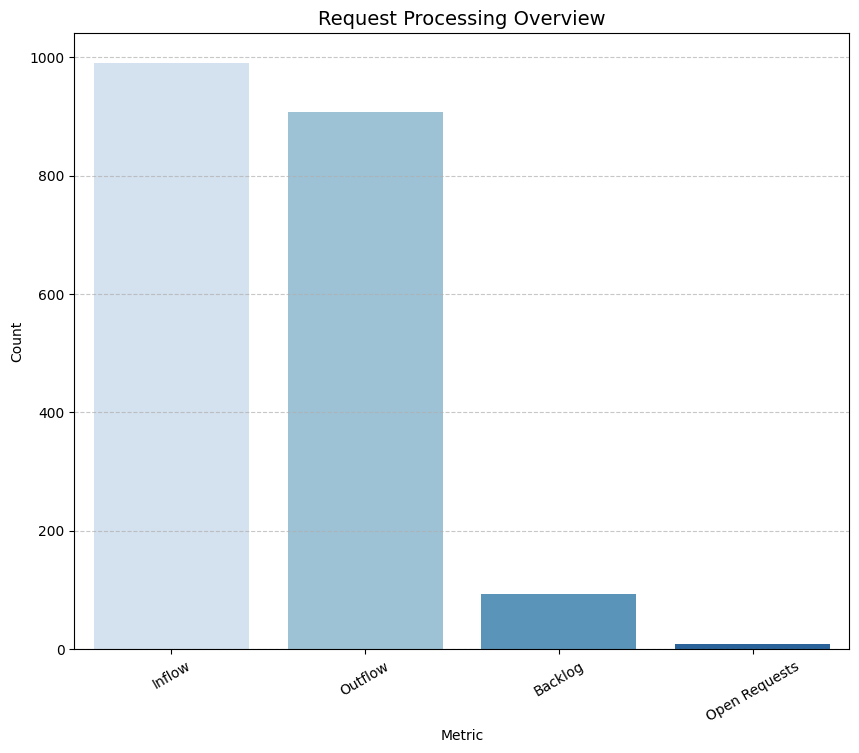

In [41]:
# Simpan hasil dalam DataFrame
result = pd.DataFrame({
    "Metric": ["Inflow", "Outflow", "Backlog", "Open Requests"],
    "Count": [inflow, outflow, backlog, open_req]
})

# Plot Bar Chart
plt.figure(figsize=(10, 8))
sns.barplot(x="Metric", y="Count", data=result, palette="Blues", hue='Metric', legend=False)

# Tambahkan label
plt.title("Request Processing Overview", fontsize=14)
plt.xlabel("Metric")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Tampilkan chart
plt.show()


In [42]:
df['Request_Month'] = df['Request_Date'].dt.to_period('M')
df['Completion_Month'] = df['Completion_Date'].dt.to_period('M')

inflow_monthly = df.groupby('Request_Month').size().rename('Inflow')
outflow_monthly = df.groupby('Completion_Month').size().rename('Outflow')

monthly = pd.concat([inflow_monthly, outflow_monthly], axis=1).fillna(0).astype(int)
monthly.index = monthly.index.to_timestamp()

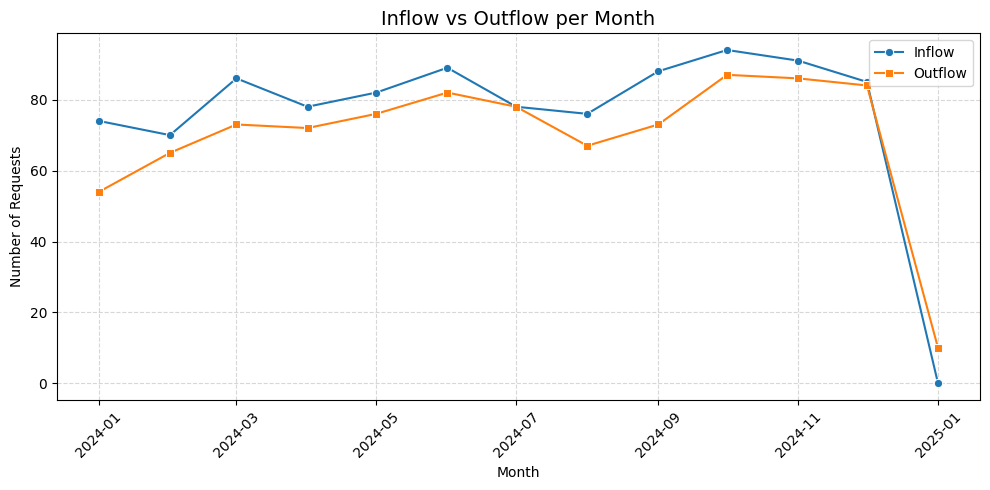

In [43]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly, x=monthly.index, y='Inflow', label='Inflow', marker='o')
sns.lineplot(data=monthly, x=monthly.index, y='Outflow', label='Outflow', marker='s')

plt.title('Inflow vs Outflow per Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
df['SLA Compliance Month'] = df['Completion_Date'].dt.to_period('M')

sla_monthly = df.groupby(['SLA Compliance Month', 'SLA Compliance']).size().unstack(fill_value=0)
sla_monthly.index = sla_monthly.index.to_timestamp()

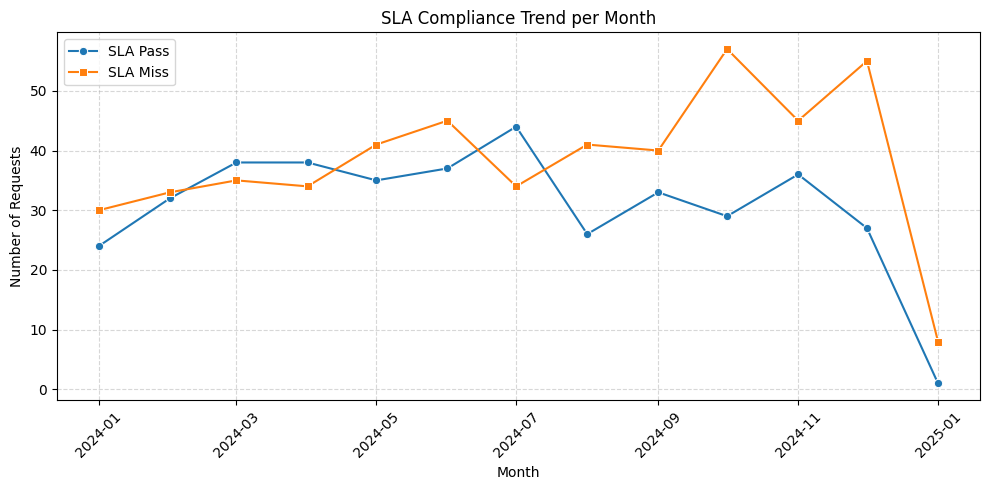

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=sla_monthly['Pass'], label='SLA Pass', marker='o')
sns.lineplot(data=sla_monthly['Miss'], label='SLA Miss', marker='s')

plt.title('SLA Compliance Trend per Month')
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()